In [140]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator
from pyspark.sql.types import DecimalType, IntegerType, DateType, DoubleType
from pyspark.ml import Pipeline

In [19]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [142]:
df = spark.read.csv('./AirBnb_NYC_2019.csv',header='true',inferSchema='true')

In [143]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'string'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'int')]

In [144]:
from pyspark.sql.functions import when,col

In [145]:
df.select('price').describe().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             48894|
|   mean|152.22296299343384|
| stddev|238.54148640283205|
|    min|         -73.99986|
|    max|      Private room|
+-------+------------------+



In [146]:
df = df.withColumn("latitude",df["latitude"].cast(DecimalType()))
df = df.withColumn("longitude",df["longitude"].cast(DecimalType()))
df = df.withColumn("price",df["price"].cast(IntegerType()))
df = df.withColumn("minimum_nights",df["minimum_nights"].cast(IntegerType()))
df = df.withColumn("number_of_reviews",df["number_of_reviews"].cast(IntegerType()))
df = df.withColumn("calculated_host_listings_count",df["calculated_host_listings_count"].cast(IntegerType()))
df = df.withColumn("last_review",df["last_review"].cast(DateType()))
df = df.withColumn("reviews_per_month",df["reviews_per_month"].cast(DoubleType()))
df = df.withColumn("availability_365",df["availability_365"].cast(IntegerType()))

df = df.withColumn("price", when(col("price")>300,300).otherwise(col("price")))
df = df.filter(df['price']>=0)
df = df.withColumn("minimum_nights", when(col("minimum_nights")>30,30).otherwise(col("minimum_nights")))
df = df.withColumn('calculated_host_listings_count', when(col('calculated_host_listings_count')>10,
                                                           10).otherwise(col('calculated_host_listings_count')))
df = df.withColumn("reviews_per_month",when(col('reviews_per_month')>10,10).otherwise(col('reviews_per_month')))
df = df.withColumn('number_of_reviews', when(col('number_of_reviews')>100,100).otherwise(col('number_of_reviews')))

In [147]:
df.select('reviews_per_month').describe().show()

+-------+-----------------+
|summary|reviews_per_month|
+-------+-----------------+
|  count|            38856|
|   mean|1.366932520074134|
| stddev|1.620253047489511|
|    min|             0.01|
|    max|             10.0|
+-------+-----------------+



In [148]:
#creates indexes for each string
indexers = [StringIndexer(inputCol=col, 
                          outputCol=col+'_index',
                         handleInvalid='keep').fit(df) for col in ['neighbourhood_group',
                                                                      'neighbourhood',
                                                                      'room_type']]
pipe = Pipeline(stages=indexers)
df = pipe.fit(df).transform(df)

#creates columns with 0 or 1 for each index
encoder = OneHotEncoderEstimator(inputCols=['neighbourhood_group_index','neighbourhood_index',
                                             'room_type_index'],
                                 outputCols=['neighbourhood_group_dummy','neighbourhood_dummy',
                                             'room_type_dummy'],
                                dropLast=True)
df = encoder.fit(df).transform(df)

df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'decimal(10,0)'),
 ('longitude', 'decimal(10,0)'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'double'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('neighbourhood_group_index', 'double'),
 ('neighbourhood_index', 'double'),
 ('room_type_index', 'double'),
 ('neighbourhood_group_dummy', 'vector'),
 ('neighbourhood_dummy', 'vector'),
 ('room_type_dummy', 'vector')]

In [149]:
df = df.na.drop()

In [150]:
target = 'price'
features = df.drop('id',
                     'name',
                     'host_id',
                     'host_name',
                     'neighbourhood_group_index',
                     'neighbourhood_index',
                     'room_type_index',
                     'neighbourhood_group',
                     'neighbourhood',
                     'room_type',
                  'price',
                  'last_review').columns

vector = VectorAssembler(inputCols= features,
                         outputCol='features')

vectorized_df = vector.transform(df)
vectorized_df = vectorized_df.select(['features','price'])
vectorized_df.show()

+--------------------+-----+
|            features|price|
+--------------------+-----+
|(529,[0,1,2,3,4,5...|  149|
|(529,[0,1,2,3,4,5...|  225|
|(529,[0,1,2,3,4,5...|   89|
|(529,[0,1,2,3,4,5...|   80|
|(529,[0,1,2,3,4,5...|  200|
|(529,[0,1,2,3,4,5...|   60|
|(529,[0,1,2,3,4,5...|   79|
|(529,[0,1,2,3,4,5...|   79|
|(529,[0,1,2,3,4,5...|  150|
|(529,[0,1,2,3,4,5...|  135|
|(529,[0,1,2,3,4,5...|   85|
|(529,[0,1,2,3,4,5...|   89|
|(529,[0,1,2,3,4,5...|   85|
|(529,[0,1,2,3,4,5...|  120|
|(529,[0,1,2,3,4,5...|  140|
|(529,[0,1,2,3,4,5...|  215|
|(529,[0,1,2,3,4,5...|  140|
|(529,[0,1,2,3,4,5...|   99|
|(529,[0,1,2,3,4,5...|  299|
|(529,[0,1,2,3,4,5...|  130|
+--------------------+-----+
only showing top 20 rows



In [151]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'decimal(10,0)'),
 ('longitude', 'decimal(10,0)'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'double'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('neighbourhood_group_index', 'double'),
 ('neighbourhood_index', 'double'),
 ('room_type_index', 'double'),
 ('neighbourhood_group_dummy', 'vector'),
 ('neighbourhood_dummy', 'vector'),
 ('room_type_dummy', 'vector')]

In [152]:
train_data, test_data = vectorized_df.randomSplit([.75,.25])

lin_reg = LinearRegression(featuresCol='features', labelCol='price')

lr = lin_reg.fit(train_data)

print("Linear Regression")
print("R^2 Value: \t",lr.summary.r2)
print("RMSE Value: \t",lr.summary.rootMeanSquaredError)

Linear Regression
R^2 Value: 	 0.5445532009797764
RMSE Value: 	 50.935641533643356


In [160]:
vector.getInputCols()

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'neighbourhood_group_dummy',
 'neighbourhood_dummy',
 'room_type_dummy']

In [153]:
lr.coefficients

DenseVector([0.0, 0.0, -1.276, -0.1416, 0.0682, -0.1853, 0.1007, 15.6995, -6.924, -14.4834, -21.7291, -22.0293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0397, -15.7707, -22.2486, -16.7564, 12.2642, 22.0195, 13.1438, 0.5264, -12.8968, 41.6202, 8.2706, -15.8678, 32.6895, 8.2735, -5.8542, -42.0049, 42.0014, 33.028, -25.1966, 12.0059, 7.8083, -24.9352, 23.0983, -26.3217, 15.8304, 23.6866, 10.401, -16.8783, -15.2284, 37.3523, -15.5757, 6.1947, -15.1707, 44.9318, 13.504, -21.1501, 16.0076, -15.7917, 40.389, 11.8765, 41.0638, -49.798, 20.8329, -5.856, 21.4105, -22.792, -10.0985, -34.023, -19.2354, -22.0299, 15.3291, 77.3563, -21.2153, -29.034, -5.9157, 27.6935, -1.1989, -36.8251, -16.615, -33.9811, -26.1821, 13.9403, -29

In [154]:
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='price')

rf = rf_reg.fit(train_data)

pred = rf.transform(train_data)

rf_eval = RegressionEvaluator(labelCol='price')
rmse = rf_eval.evaluate(pred)

print("Random Forrest Regression")
print("RMSE Value: \t",rmse)

Random Forrest Regression
RMSE Value: 	 53.83965150068895


In [155]:
gbt_reg = GBTRegressor(featuresCol='features', labelCol='price')

gbt = gbt_reg.fit(train_data)

pred = gbt.transform(train_data)

gbt_eval = RegressionEvaluator(labelCol='price')
rmse = gbt_eval.evaluate(pred)

print("Random Forrest Regression")
print("RMSE Value: \t",rmse)

Random Forrest Regression
RMSE Value: 	 49.891347319402065


In [156]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'decimal(10,0)'),
 ('longitude', 'decimal(10,0)'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'double'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('neighbourhood_group_index', 'double'),
 ('neighbourhood_index', 'double'),
 ('room_type_index', 'double'),
 ('neighbourhood_group_dummy', 'vector'),
 ('neighbourhood_dummy', 'vector'),
 ('room_type_dummy', 'vector')]

In [157]:
train_data.describe().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             28981|
|   mean|127.13067181946792|
| stddev| 75.47627293334118|
|    min|                 0|
|    max|               300|
+-------+------------------+



In [113]:
import pandas as pd

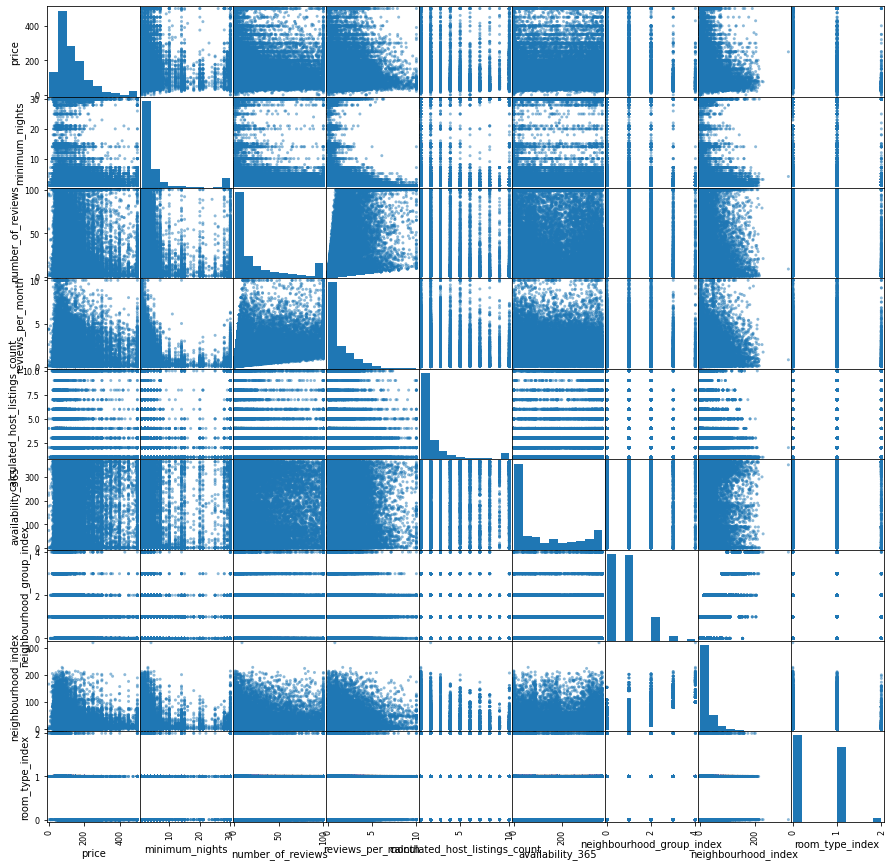

In [114]:
numeric = [col[0] for col in df.dtypes if col[1] in ['int','float','double','decimal(10,0)']]
data_mat = df.select(numeric).toPandas()
data_mat.reviews_per_month = data_mat.reviews_per_month.astype(float)
pd.plotting.scatter_matrix(data_mat, figsize=(15,15));

In [162]:
data_mat.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_index,neighbourhood_index,room_type_index
count,38678.000000,38678.000000,38678.000000,38678.000000,38678.000000,38678.000000,38678.000000,38678.000000,38678.000000
mean,134.088914,5.158772,24.310202,1.363453,2.102255,114.696546,0.757950,22.097446,0.497906
std,95.767486,7.730460,30.748825,1.617184,2.260286,129.508809,0.805646,30.121586,0.541938
min,0.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,69.000000,1.000000,3.000000,0.190000,1.000000,0.000000,0.000000,3.000000,0.000000
50%,102.000000,2.000000,9.000000,0.710000,1.000000,55.000000,1.000000,10.000000,0.000000
75%,170.000000,4.000000,33.000000,2.010000,2.000000,229.000000,1.000000,29.000000,1.000000
max,500.000000,30.000000,100.000000,10.000000,10.000000,365.000000,4.000000,319.000000,2.000000
